In [699]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from datetime import date
import re
pd.reset_option('display.float_format')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Run the Scraper Notebook first to export Stock_Scrape.csv and Stock_ScrapeQ.csv to the working directory**

In [700]:
#import scraped stocks

df = pd.read_csv('Stock_Scrape.csv', index_col = 0) #YE2019 
dfQ = pd.read_csv('Stock_ScrapeQ.csv', index_col = 0) #MRQ
df = df.replace('-', 0).reset_index()
dfQ = dfQ.replace('-', 0).reset_index()

In [701]:
#Get List of S&P
companies = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')
Symbol = companies.Symbol
companies.columns = ['Ticker', 'Name', 'Sector']

In [702]:
def convert(string):
    
    try:
        #try a mathematical calculation to check if already a number
        # if it is simply return value
        int(64) * int(string)
        return(float(string))
    
    except:
               
        #find parenthetical, B, or M indicators
        regex = re.compile(r'[\( \)]')
        p = ''.join(regex.findall(string))

        regex = re.compile(r'B')
        b = ''.join(regex.findall(string))

        regex = re.compile(r'M')
        m = ''.join(regex.findall(string))

        #negative if enclosed in parenthetical
        if p == '()':
            neg = -1
        else:
            neg = 1

        #Billions if ends in B
        if b == 'B':
            mult = 1000000

        #Millions if ends in B
        elif m == 'M':
            mult = 1000
        else:
            mult = 1

        #pull out the number
        regex = re.compile(r'\d+(\..*)?\d')
        value = regex.search(string)

        #convert to integer
        try:
            value = float(value.group())
        except:
            value = 0

        #multiply by negative flag and multiple established above
        return round(float(value) * neg * mult,2)


In [703]:
def pconvert(x):
    x = str(x).replace('%','')
    x = str(x).replace(',','')
    return x

In [704]:
#function to convert data in dataframes

def DataConversions(data):
    data.epsgrowth = data.epsgrowth.apply(pconvert).astype(float)
    data.roa = data.roa.apply(pconvert).astype(float)
    data.eps = data.eps.apply(convert).astype(float)
    data.netincome = data.netincome.apply(convert).astype('int64')
    data.shareholderequity = data.shareholderequity.apply(convert).astype('int64')
    data.longtermdebt = data.longtermdebt.apply(convert).astype('int64')
    data.interestexpense = data.interestexpense.apply(convert).astype('int64')
    data.ebitda = data.ebitda.apply(convert).astype('int64')
    data['ST Debt'] = data['ST Debt'].apply(convert).astype('int64')
    data.Cash = data.Cash.apply(convert).astype('int64')
    data = data[data.Cash>0] #remove companies with no cash
    data['TotalDebt'] = data.longtermdebt + data['ST Debt']
    data['D2C'] = data.TotalDebt / data.Cash
    
    return data

In [705]:
# convert the text to numbers based on my function

df = DataConversions(df)
dfQ = DataConversions(dfQ)


C:\Users\nmur1\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\nmur1\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [706]:
#filter my fundamentals

def Filter(data, tfilt, quant):
    data = data[data['index'] == tfilt]
    data = data[data.D2C < data['D2C'].quantile(quant)]
    return data

#filter 2019 D2C in the top 98th percentile to try and get the super high outliers
df2019 = Filter(df,2019,.98)

#create a dataframe for the trailing 12 month eps
dfQ = dfQ[dfQ['index'] != 'MRQ-4'].sort_values(by = 'Ticker')
epsQ = dfQ.loc[:,('Ticker','eps')]
epsQ.columns = ['Ticker', 'epsTTM']
epsQ = epsQ.groupby('Ticker').sum()

#create a dataframe for the most recent quarter's Debt to Cash Ratio
MRQ_D2C = dfQ[dfQ['index'] == 'MRQ'].loc[:,('Ticker','D2C', 'TotalDebt', 'epsgrowth')]
MRQ_D2C.columns = ['Ticker', 'MRQ_D2C', 'MRQ_TotalDebt', 'MRQ_epsGrowth']

dfQ[dfQ.Ticker == 'MET']

,index,eps,epsgrowth,netincome,shareholderequity,roa,longtermdebt,interestexpense,ebitda,ST Debt,Cash,Ticker,TotalDebt,D2C
1556,MRQ-3,1.78,26.19,1750000,63810000,8.72,19030000,2280000,0,0,18440000,MET,19030000,1.031996
1557,MRQ-2,2.32,30.07,2190000,68370000,9.20,19160000,2820000,0,0,19450000,MET,19160000,0.985090
1558,MRQ-1,0.58,-74.80,588000,66140000,8.86,18980000,265000,0,0,16600000,MET,18980000,1.143373
1559,MRQ,4.78,718.70,4400000,70220000,9.52,18640000,5680000,0,0,24090000,MET,18640000,0.773765


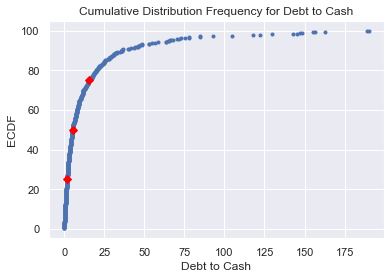

In [726]:
# run an ECDF on 2019's D2C
pD2C = np.percentile(df2019.D2C, np.array([25, 50, 75]))

sns.set()
x = np.sort(df2019.D2C)
y = np.arange(1, len(x) + 1) / len(x) * 100


ecdf = plt.plot(x, y, marker = '.', linestyle = 'none')
ecdf = plt.plot(pD2C, np.array([25,50,75]), marker = 'D', color = 'red', linestyle = 'none' )
ecdf = plt.xlabel('Debt to Cash')
ecdf = plt.ylabel('ECDF')
ecdf = plt.title('Cumulative Distribution Frequency for Debt to Cash')
ecdf = plt.savefig('ECDF')
plt.margins = .02
plt.show()


In [708]:
import yfinance as yf
def Pricing(ticker, dstart, dend, Type):

    df = yf.download(ticker, 
                          start=dstart, 
                          end = dend,
                          progress=False, group_by = 'Ticker')

    df = df.reset_index()
    df = df.melt(id_vars = 'Date', var_name = ['Ticker', 'Type'])
    df = df[df.Type == Type]
    
    return df


In [709]:
#create YE stock price dataframe
YE2019 = Pricing(list(Symbol), '2019-12-31', '2020-01-02', 'Close')
YE2019 = YE2019[YE2019.Date == '2019-12-31']


6 Failed downloads:
- CARR: Data doesn't exist for startDate = 1577768400, endDate = 1577941200
- BF.B: No data found for this date range, symbol may be delisted
- OTIS: Data doesn't exist for startDate = 1577768400, endDate = 1577941200
- TT: No data found for this date range, symbol may be delisted
- HWM: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [710]:
def RollingPrice(sdate, edate, lookback):
    YTDPrice = Pricing(list(Symbol), sdate, edate, 'Close')
    YTDPrice = YTDPrice.sort_values(by = ['Ticker','Date'])
    YTDPrice['Rolling'] = YTDPrice.value.rolling(window = lookback).mean()
    Rolling = YTDPrice[YTDPrice.Date == YTDPrice.Date.max()]
    print(Rolling.Date.max())
    Rolling = Rolling.loc[:,('Ticker','Rolling')]
    return Rolling

Rolling = RollingPrice('2019-12-31', '2020-06-18',30)


2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
2020-06-17 00:00:00


In [711]:
#subset the YE pricing to include only the ticker and price
p2019 = YE2019.loc[:,('Ticker','value')]
p2019.columns = ['Ticker', 'YEPrice']


In [712]:
new = pd.merge(df2019,p2019,on = 'Ticker', how = 'left')
new = pd.merge(new,epsQ, on ='Ticker', how = 'left')
new = pd.merge(new, Rolling, on = 'Ticker', how = 'left')
new = pd.merge(new,MRQ_D2C, on = 'Ticker', how = 'left' )
new = pd.merge(new, companies, on = 'Ticker')

new['YEPE'] = new.YEPrice / new.eps
new['peTTM'] = new.Rolling / new.epsTTM
new['PEVariance'] = new.peTTM - new.YEPE
new['D2CChange'] = (new.MRQ_D2C - new.D2C) / new.D2C

In [713]:
new.columns

Index(['index', 'eps', 'epsgrowth', 'netincome', 'shareholderequity', 'roa',
       'longtermdebt', 'interestexpense', 'ebitda', 'ST Debt', 'Cash',
       'Ticker', 'TotalDebt', 'D2C', 'YEPrice', 'epsTTM', 'Rolling', 'MRQ_D2C',
       'MRQ_TotalDebt', 'MRQ_epsGrowth', 'Name', 'Sector', 'YEPE', 'peTTM',
       'PEVariance', 'D2CChange'],
      dtype='object')

In [714]:
def ExtraC(row):
    
    points = 0
    epsGrowth = row['MRQ_epsGrowth']
    debtdec = row['Change in Debt']
    
    if epsGrowth > 0:
        points = points + 1
    
    if debtdec < 0:
        points = points + 1
    
    return points

In [737]:
top25 = new.D2C.quantile(.25)

#Filters
PickList = new[new.D2C <= top25]
PickList = PickList[PickList.epsgrowth > 0]
PickList = PickList[PickList.PEVariance < 0]
PickList = PickList[PickList.D2CChange < .10]
PickList = PickList[PickList.epsTTM > 0]

#final table
PickList = PickList.loc[:,('Ticker','Name', 'Sector','eps','epsTTM','MRQ_epsGrowth', 'YEPE', 'peTTM', 'PEVariance', 'D2C', 'MRQ_D2C', 'D2CChange', 'TotalDebt', 'MRQ_TotalDebt')]
#PickList.to_excel('PickList.xlsx')
PickList.TotalDebt = PickList.TotalDebt/1000
PickList.MRQ_TotalDebt = PickList.MRQ_TotalDebt/1000
PickList.MRQ_epsGrowth = PickList.MRQ_epsGrowth/100
PickList['Change in Debt'] = PickList.MRQ_TotalDebt - PickList.TotalDebt
PickList['ExtraCredit'] = PickList.apply(ExtraC, axis = 1)

In [738]:
PickList = PickList.sort_values(by = 'ExtraCredit', ascending = False)
PickList.to_excel('PickList.xlsx')

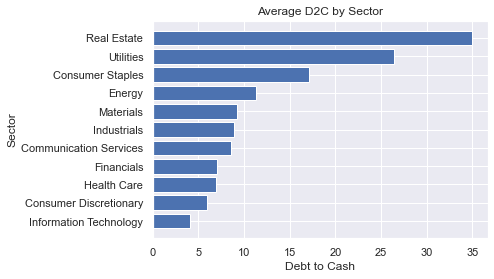

<Figure size 432x288 with 0 Axes>

In [759]:
x = pd.DataFrame(new.groupby('Sector')['MRQ_D2C'].mean()).reset_index()
x = x.sort_values(by = 'MRQ_D2C')

_ = plt.barh(x['Sector'],x['MRQ_D2C'])
_ = plt.xlabel('Debt to Cash')
_ = plt.ylabel('Sector')
_ = plt.title('Average D2C by Sector')

plt.figsize = (40,40)
plt.show()
plt.savefig('AverageD2C')

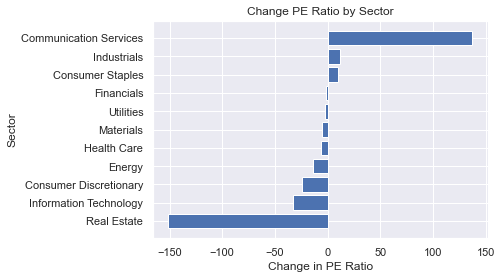

<Figure size 432x288 with 0 Axes>

In [769]:
x = pd.DataFrame(new.groupby('Sector')['PEVariance'].mean()).reset_index()
x = x.sort_values(by = 'PEVariance', ascending = True)

_ = plt.barh(x['Sector'],x['PEVariance'])
_ = plt.xlabel('Change in PE Ratio')
_ = plt.ylabel('Sector')
_ = plt.title('Change PE Ratio by Sector')

_ = plt.figsize = (500,500)
plt.show()
plt.savefig('AverageD2C')